In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 6,249
training + validation N: 24,234


,set,tot_ct,ex_ct,y,x
0,training,28,2,0.023406,GGAGUGAUG
1,training,315,7,-0.587914,AGUGUGCAA
2,validation,27,0,-0.438475,UAAGCUUUU
3,training,130,2,-0.631467,AUGGUCGGG
4,training,552,19,-0.433012,AGGGCAGGA
5,training,151,184,1.094011,AAGGUCCGC
6,training,88,4,-0.241737,CAGGCAAAC
7,training,105,5,-0.238471,GUGGCAAAU
8,validation,14,0,-0.167408,CAUGCAGCU
9,training,170,14,-0.048222,CAAGUCACU


In [3]:
# Get sequence length
L = len(data_df['x'][0])

# Define model
model = mavenn.Model(L=L,
                     alphabet='rna',
                     gpmap_type='pairwise', 
                     regression_type='GE',
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

In [4]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

N = 24,234 observations set as training data.
Using 24.8% for validation.
Data shuffled.
Time to set data: 0.392 sec.


In [5]:
# Fit model to data
model.fit(learning_rate=.001,
          epochs=1000,
          batch_size=50,
          early_stopping=True,
          early_stopping_patience=30,
          linear_initialization=False)

Epoch 1/1000
365/365 [==============================] - 1s 3ms/step - loss: 63.6323 - I_var: -0.3366 - val_loss: 55.0362 - val_I_var: -0.1263
Epoch 2/1000
365/365 [==============================] - 1s 2ms/step - loss: 50.6860 - I_var: -0.0209 - val_loss: 47.2711 - val_I_var: 0.0632
Epoch 3/1000
365/365 [==============================] - 1s 2ms/step - loss: 45.4024 - I_var: 0.1120 - val_loss: 43.7098 - val_I_var: 0.1559
Epoch 4/1000
365/365 [==============================] - 1s 2ms/step - loss: 43.3491 - I_var: 0.1672 - val_loss: 42.5630 - val_I_var: 0.1866
Epoch 5/1000
365/365 [==============================] - 1s 2ms/step - loss: 42.5546 - I_var: 0.1884 - val_loss: 42.1647 - val_I_var: 0.1983
Epoch 6/1000
365/365 [==============================] - 1s 3ms/step - loss: 42.1751 - I_var: 0.1989 - val_loss: 41.8022 - val_I_var: 0.2083
Epoch 7/1000
365/365 [==============================] - 1s 3ms/step - loss: 41.9473 - I_var: 0.2052 - val_loss: 41.6037 - val_I_var: 0.2138
Epoch 8/1000
365/

365/365 [==============================] - 1s 2ms/step - loss: 39.6943 - I_var: 0.2821 - val_loss: 39.3571 - val_I_var: 0.2903
Epoch 60/1000
365/365 [==============================] - 1s 2ms/step - loss: 39.6456 - I_var: 0.2844 - val_loss: 39.1710 - val_I_var: 0.2969
Epoch 61/1000
365/365 [==============================] - 1s 3ms/step - loss: 39.5939 - I_var: 0.2871 - val_loss: 38.8625 - val_I_var: 0.3063
Epoch 62/1000
365/365 [==============================] - 1s 3ms/step - loss: 39.4024 - I_var: 0.2939 - val_loss: 38.7360 - val_I_var: 0.3112
Epoch 63/1000
365/365 [==============================] - 1s 2ms/step - loss: 39.1906 - I_var: 0.3020 - val_loss: 38.6230 - val_I_var: 0.3162
Epoch 64/1000
365/365 [==============================] - 1s 2ms/step - loss: 38.8685 - I_var: 0.3126 - val_loss: 37.9323 - val_I_var: 0.3387
Epoch 65/1000
365/365 [==============================] - 1s 3ms/step - loss: 38.4555 - I_var: 0.3257 - val_loss: 38.0921 - val_I_var: 0.3354
Epoch 66/1000
365/365 [====

In [6]:
# Save model
model.save('mpsa_ge_pairwise')

Model saved to these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [7]:
# Load model
model = mavenn.load('mpsa_ge_pairwise')

Model loaded from these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [8]:
# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values

On test data:
I_var_test: 0.329 +- 0.027 bits
I_pred_test: 0.368 +- 0.013 bits


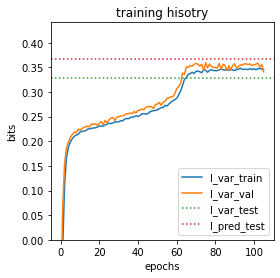

In [9]:
# Show training history
print('On test data:')

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

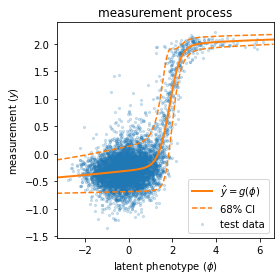

In [10]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

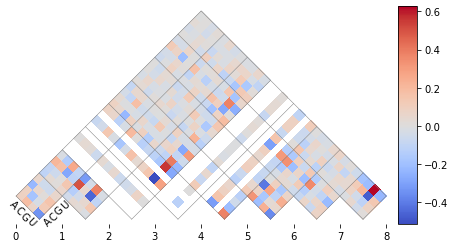

In [11]:
# Plot pairwise parameters
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],
                        alphabet=theta['alphabet'],
                        ax=ax);

In [12]:
# Test simulate_data
sim_df = model.simulate_dataset(N=1000)
sim_df.head()

,set,yhat,phi,y,x
0,validation,-0.327926,-0.541973,-0.330788,UAAGCGACC
1,validation,-0.354729,-1.208897,-0.206976,UCUGCCAAU
2,training,-0.291322,0.272894,-0.329993,UUAGUAGUC
3,training,1.377984,2.117125,1.287107,GGAGUGAGU
4,training,-0.390895,-2.148078,-0.251880,AUCGCUAGA


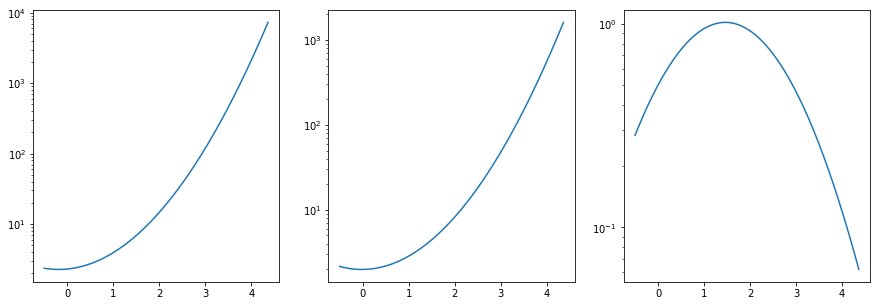

In [13]:
# Is clip by value causing a problem?
yhat_fixed = (yhat_grid - model.y_mean)/model.y_std
a, b, s = model.layer_noise_model.compute_params(yhat_fixed)

fig, axs = plt.subplots(1,3,figsize=[15,5])

axs[0].semilogy(yhat_fixed, a)
axs[1].semilogy(yhat_fixed, b)
axs[2].semilogy(yhat_fixed, s)